# Crop BSE images

Håkon Wiik Ånes (hakon.w.anes@ntnu.no), 2022-11-29, Norwegian University of Science and Technology (NTNU)

Crop backscatter electron (BSE) images prior to and after stitching with *BigStitcher* in *ImageJ*.

In [1]:
# Use the qt5 backend for interactive plotting (from the pyqt package)
%matplotlib inline

from datetime import date
import importlib_metadata
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
import skimage.color as skc
import skimage.exposure as ske
import skimage.io as ski
import skimage.transform as skt


# Directories
sample = "175c"
dset_no = 3
dir_data = f"/home/hakon/phd/data/p/prover/{sample}/{dset_no}"
dir_bse = os.path.join(dir_data, "bse")
dir_kp = os.path.join(dir_data, "kp")

print("Run date: ", date.today())
print("\nSoftware versions\n-----------------")
for pkg in ["matplotlib", "numpy", "scipy", "scikit-image"]:
    if pkg == "numpy":
        ver = np.__version__
    else:
        ver = importlib_metadata.version(pkg)
    print(pkg, ":", ver)

Run date:  2022-11-29

Software versions
-----------------
matplotlib : 3.6.2
numpy : 1.23.5
scipy : 1.9.3
scikit-image : 0.19.3


## Image layout and corrections

BSE images, from 4-6 for each region of interest (ROI), are acquired with some overlap.
The goal is to combine these images into a single image per ROI (dataset).
To improve the result of the combination using *BigStitcher*, each image is sliced to reduce the necessary overlap.
Also, some warping was observed between images in the same ROI due to scan drift (approx. 3 min. acquisition time per BSE image).
This warping is accounted for using a transformation function composed of very slight shear and (x, y) scaling, followed by a very slight rotation.

The below parameters were found manually from trial-and-error.

The images in an ROI make up a layout (usually without ML, MR)

```
| UL | UR |
| ML | MR |
| LL | LR |
```

meaning UL - upper left, UR - upper right, ML - middle left, MR - middle right, LL - lower left and LR - lower right.
If not specified, the order is UL, UR, LR, LL.

In [2]:
slices = {
    "0s": {
        1: [
            # (top, bottom), (left, right)
            (slice(0, -359), slice(0, -350)),
            (slice(0, -200), slice(50, -1)),
            (slice(0, -1), slice(450, -1)),
            (slice(0, -1), slice(0, -1))
        ],
        2: [
            (slice(0, -1), slice(40, -150)),  # UL
            (slice(0, -1), slice(80, -50)),  # UR
            (slice(0, -1), slice(100, -50)),  # MR
            (slice(0, -50), slice(40, -50)),  # ML
            (slice(0, -1), slice(50, -1)),  # LR
            (slice(0, -1), slice(40, -50)),  # LL
        ],
        3: [
            (slice(0, -250), slice(40, -440)),  # UL
            (slice(0, -50), slice(30, -1)),  # UR
            (slice(0, -1), slice(150, -1)),  # MR
            (slice(0, -1), slice(40, -1)),  # ML
            (slice(300, -1), slice(30, -1)),  # LR
            (slice(0, -1), slice(330, -1)),  # LL
        ],
    },
    "175c": {
        1: [
            (slice(0, -40), slice(40, -60)),
            (slice(0, -130), slice(250, -1)),
            (slice(50, -1), slice(40, -1)),
            (slice(40, -1), slice(40, -20)),
        ],
        2: [
            (slice(0, -75), slice(40, -75)),  # UL
            (slice(0, -50), slice(40, -1)),  # UR
            (slice(50, -50), slice(65, -1)),  # MR
            (slice(75, -75), slice(40, -100)),  # ML
            (slice(50, -1), slice(40, -50)),  # LL
            (slice(20, -1), slice(40, -1)),  # LR
        ],
        3: [
            (slice(800, 1200), slice(2200, 2800)),  # Center
            (slice(0, -50), slice(40, -190)),  # UL
            (slice(0, -150), slice(100, -1)),  # UR
            (slice(50, -1), slice(280, -1)),  # LR
            (slice(100, -1), slice(40, -1)),  # LL
        ]
    },
    "300c": {
        1: [
            (slice(0, -150), slice(0, -300)),
            (slice(0, -50), slice(125, -1)),
            (slice(300, -1), slice(150, -1)),
            (slice(200, -1), slice(0, -150)),
        ],
        2: [ # ??
            (slice(0, -100), slice(0, -100)),
            (slice(0, -100), slice(0, -100)),
            (slice(0, -100), slice(0, -100)),
            (slice(0, -100), slice(0, -100)),
        ],
        3: [
            (slice(0, -150), slice(0, -300)),
            (slice(0, -50), slice(125, -1)),
            (slice(300, -1), slice(150, -1)),
            (slice(200, -1), slice(0, -150)),
        ],
    },
    "325c": {
        1: [
            (slice(0, -300), slice(40, -750)),
            (slice(0, -200), slice(40, -1)),
            (slice(120, -1), slice(40, -1)),
            (slice(0, -1), slice(40, -150)),
        ],
        2: [
            (slice(0, -300), slice(40, -300)),
            (slice(0, -300), slice(275, -1)),
            (slice(0, -1), slice(300, -1)),
            (slice(0, -1), slice(40, -230)),
        ],
        3: [
            (slice(0, -570), slice(40, -350)),
            (slice(0, -240), slice(110, -1)),
            (slice(290, -1), slice(40, -1)),
            (slice(0, -1), slice(40, -190)),
        ],
    },
}

Warp image using an affine transformation composed by shear and (x, y) scaling, `(shear, [scale_x, scale_y])`

In [3]:
warp = {
    "0s": {
        1: [(0.0172, [1, 1]), (0, [1, 1]), (0, [1, 1]), (0, [1, 1])],
        2: [(0, [1, 1]), (0, [1, 1]), (0, [1, 1]), (0, [1, 1]), (0, [1, 1]), (0, [1, 1])],
        3: [(0, [1, 1]),(0, [1, 1]), (0, [1, 1]), (0, [1, 1]), (0, [1, 1]), (0, [1, 1])],
    },
    "175c": {
        1: [(0, [1, 1]), (0, [1, 1]), (0, [1, 1]), (0, [1, 1])],
        2: [(0, [1, 1]), (0, [1, 1]), (0, [1, 1]), (0, [1, 1]), (0, [1, 1]), (0, [1, 1])],
        3: [(0, [1, 1]), (0, [1, 0.995]), (0, [1, 1]), (0, [1, 1]), (0, [1, 1.005])],
    },
    "300c": {
        1: [(0, [1, 1]), (0, [1, 1]), (0, [1, 1]), (0, [1, 1])],
        2: [(0, [1, 1]), (0, [1, 1]), (0, [1, 1]), (0, [1, 1])],
        3: [(0, [1, 1]), (0, [1, 1]), (0, [1, 1]), (0, [1, 1])],
    },
    "325c": {
        1: [(0, [1, 1]), (0, [1, 1]), (0, [1, 1]), (0, [1, 1])],
        2: [(-0.005, [1, 0.993]), (0, [1, 1]), (0, [1, 1]), (-0.005, [1, 1.005])],
        3: [(0, [1, 1]), (0, [1, 1]), (0, [1, 1]), (0.0119, [1, 1])],
    },
}

Clock-wise rotation in degrees

In [4]:
rotate = {
    "0s": {
        1: [0, 0, 0, 0],
        2: [0, 0, 0, 0, 0, 0],
        3: [0, 0, 0, 0, -0.9, -0.9],
    },
    "175c": {
        1: [0.2, 0, 0, 0.15],
        2: [0, 0, 0, 0, 0, 0],
        3: [0, 0, 0, 0, 0],
    },
    "300c": {
        1: [0, 0, 0, 0],
        2: [0, 0, 0, 0],
        3: [0, 0, 0, 0],
    },
    "325c": {
        1: [0, 0, 0, 0],
        2: [0, 0, 0, 0],
        3: [0, 0, 0, 0],
    },
}

## Crop and correct images for *BigStitcher*

Load images, process them, and save to TIFFs, to be loaded into *BigStitcher*

In [5]:
for i in range(1, len(slices[sample][dset_no]) + 1):
    # Crop away banner with microscope information
    img0 = plt.imread(os.path.join(dir_bse, f"4500x{i}.tif"))
    img1 = img0[:2072]
    img2 = skc.rgb2gray(img1[..., :3])
    img3 = ske.rescale_intensity(img2, out_range="uint8")

    ski.imsave(os.path.join(dir_bse, f"4500x{i}_cropped.tif"), img3)

    img4 = img3.copy()

    # Fix possible shear
    shear_i, scale_i = warp[sample][dset_no][i - 1]
    if shear_i != 0 or not np.allclose(scale_i, [1, 1]):
        tform = skt.AffineTransform(shear=shear_i, scale=scale_i)
        img4 = skt.warp(img4, tform.inverse)
        img4 = ske.rescale_intensity(img4, out_range="uint8")

    # Fix possible (small) rotation between images
    angle = rotate[sample][dset_no][i - 1]
    if angle != 0:
        img4 = ndi.rotate(img4, angle, reshape=False)

    # Crop again for better overlap with BigStitcher in ImageJ
    img4 = img4[slices[sample][dset_no][i - 1]]

    ski.imsave(os.path.join(dir_bse, f"4500x{i}_cropped2.tif"), img4)

## Crop image fused with *BigStitcher*

Final adjustment of fused image

In [6]:
# Indices are inclusive in the first slice, exclusive in the second
# BSE
bse_slice = {
    "0s": {
        1: (slice(28, 3795), slice(43, 5634)),
        2: (slice(36, 5973), slice(171, 5946)),
        3: (slice(10, 5531), slice(313, 5712)),
    },
    "175c": {
        1: (slice(30, 3938), slice(265, 6050)),
        2: (slice(114, 5879), slice(295, 5936)),
        3: (slice(220, 3890), slice(546, 5759)),
    },
    "300c": {
        1: (slice(25, 3949), slice(50, 5289)),
        2: (slice(2, 3749), slice(124, 5576)),
        3: (slice(16, 3837), slice(137, 5799))
    },
    "325c": {
        1: (slice(2, 3795), slice(571, -2)),
        2: (slice(28, 3811), slice(17, 5500)),
        3: (slice(27, 3570), slice(199, 5786)),
    },
}

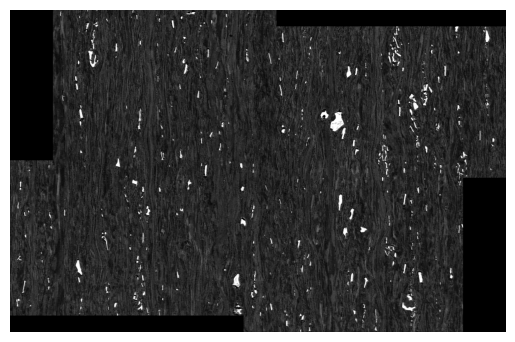

In [7]:
img5 = plt.imread(os.path.join(dir_bse, "4500x_cropped2_fused.png"))
img6 = ske.rescale_intensity(img5, out_range="uint8")
fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(img5, cmap="gray");

Crop for histogram matching (in `ImageJ`) and particle detection

In [8]:
ski.imsave(
    os.path.join(dir_bse, "4500x_cropped2_fused_cropped.png"),
    img6[bse_slice[sample][dset_no]]
)